In [1]:
# More inports than nessasary...
import os
from pathlib import Path
import geopandas as gpd
import xarray as xr

# Block of imports needed for GRIDtool.grid_area_weighted_volume
import rasterio as rio
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt



mwb_flow_dir = r'C:\Users\CND905\Downloaded_Programs\mwb_flow'
os.chdir(mwb_flow_dir)

from prep.datafile import CreateInputFile
from prep.metdata import get_gridmet_for_polygons
from prep.datafile import check_format
from prep.q_datafile import Get_Flow_Data

import py3dep
from tqdm import tqdm
from config import GRIDMET_PARAMS
import GRIDtools as gt

Initializing mwb_flow.prep module.


## Create an function that returns geometry column from either a shape file or geodataframe of lat and lon

Polygon geometries can come from two spots. Those being a (1)shp file or (2)a geodataframe of coordinates.

Create a function that returns polygon geometires with an ID column and can intake either of the above options.

In [ ]:
# # Create geopandas.GeoDataFrame of some points we want to delineate upstream catchments for
# pour_pnt = gpd.GeoDataFrame(
#     {
#         "name": ["Soda Butte Cr at Park Bndry", 'Lamar River nr Tower Ranger'],
#     },
#     geometry=[Point(-110.0018722, 45.00283056), Point(-110.3942694, 44.92817778)],
#     crs=4326
# )

# watershed_gdf = gt.delineate_watershed(pour_pnt)
# watershed_gdf["catchmentID"] = ['06187915', '06188000'] # Does the code need an ID column as an int?

# watershed_gdf.boundary.plot()
# watershed_gdf

,req_idx,catchmentID,geometry,Area_sqKm,name,direction,upstream,gnis_name,comid,reachcode,intersection_point
0,0,06187915,"POLYGON ((-110.00979 44.97979, -110.00979 44.9...",80.116374,Soda Butte,up,True,Soda Butte Creek,2962790,10070001001206,"[-110.00253513072141, 45.0029964223079]"


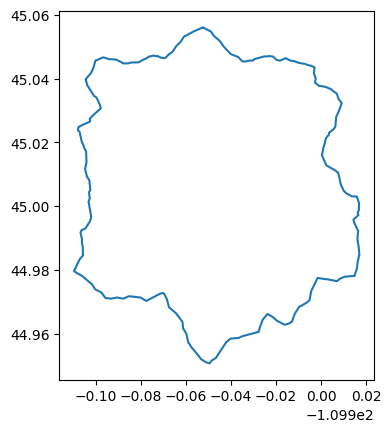

In [2]:
# Create geopandas.GeoDataFrame of some points we want to delineate upstream catchments for
pour_pnt = gpd.GeoDataFrame(
    {
        "name": ["Soda Butte"],
    },
    geometry=[Point(-110.0018722, 45.00283056)],
    crs=4326
)

watershed_gdf = gt.delineate_watershed(pour_pnt)
watershed_gdf["catchmentID"] = '06187915' # Does the code need an ID column as an int?

watershed_gdf.boundary.plot()
watershed_gdf

getting site 06187915, 1998-10-01 - 2024-12-31...


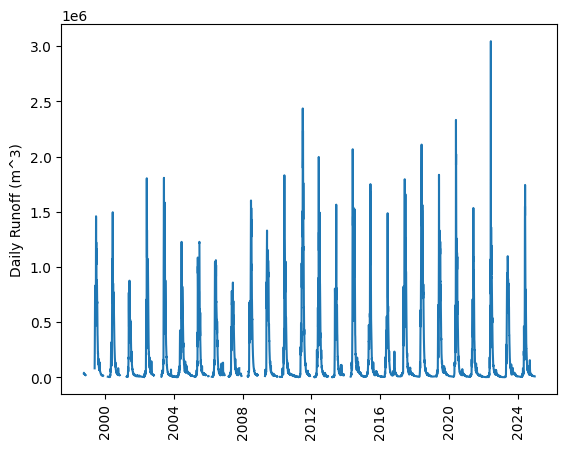

In [3]:
get_flow_data = Get_Flow_Data(start='1998-10-01', end='2024-12-31', source='get_usgs', site_number=watershed_gdf["catchmentID"])
q_volume = get_flow_data.create_dataframe()

q_volume
x = q_volume['time'].values
y1 = q_volume.discharge_volume.values[0,:]

plt.xticks(rotation=90)
plt.plot(x, y1)
plt.ylabel("Daily Runoff (m^3)")
plt.show()

## Update the code for getting zonal stats
The code to get_gridmet_for_polygons has been updated to use xvec and get a precip volume. 

In [ ]:
exres_met = get_gridmet_for_polygons(in_geom=watershed_gdf, gdf_index_col="catchmentID", start='1998-10-01', end='2024-12-31')
exres_met

## Make function that returns an array of monthly discharge values. The data can be brought in from usgs, stage or uploaded as a file
